In [1]:
import os
from fitting_code import FitModel
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
import input_checker as ic
import json
import lammps
import glob
from matplotlib import gridspec
import seaborn as sns
import fitting_output as fit_out

In [2]:
def get_lattice(fit_data, values, args):
    """
    Returns relaxed structures with the parameters from the fitted potential implemented.
    Args:
        fit_data (obj(FitModel)): all structural data and associated properties defined, with methods for implementing the fitting process using LAMMPS. 
        values (list(float)): Values relating to the fitting arguments passes in.
        args (list(str)): Keys relating to the fitting parameters for the system, such as charge, springs, and buckingham parameters.
    Returns:
        lmp (obj): Lammps object with structure and specified commands implemented, after MD minimisation and relaxation.
    """
    fit_data.init_potential(values, args)
    lmp = fit_data.get_lattice_params()
    return lmp

def differences(lattice_params, ref):
    """
    Returns relaxed structures with the parameters from the fitted potential implemented.
    Args:
        lattice_params (np.array): lattice parameters (a,b,c) and volume of fitted MD parameters.
        ref (np.array): lattice parameters (a,b,c) and volume of DFT reference values.
    Returns:
        (np.array): Percentage differences between MD (lattice_params) and DFT (ref) lattice parameters.
    """
    return ((lattice_params-ref)/ref)*100

## Setup of fitting parameters for your structure (Example: LiNiO2)
Params is the dictionary (of dictionaries) which contains the main information relating to the system and potentials. There are 5 sub dictionaries: core_shell, charges, masses, potentials, and cs_springs.

**core_shell**: The keys are each atom type within the structure, with the relating value a boolean expression stating if that atom type is core-shell or not i.e. True = core-shell, False = rigid ion.

**charges**: The keys are again each atom type within the structure. The relating value is either a float representation of the atomic charge (for rigid ion atoms) or a sub dictionary where the sub keys are 'core' and 'shell', with the relating sub values being a float representation of the charge. Note: if you are fitting the charge separation (dq), the formal charge should be on the core and 0.0 charge on the shell.

**masses**: Similar to charges, the keys are each atom type within the structure, with the values either a float representation of the atomic mass, or a sub directory with the sub keys 'core' and 'shell' and sub values a float representation of the mass on each (summing to the atomic mass). Mass can not be fitted, and there is no definative way of splitting the mass, however convention suggests having 10 % mass on the shell.

**potentials**: The keys are atom label pairs separated by a dash (str), example: 'Li-O'. The values are a list of the buckingham potential parameters, i.e. [a, rho, c], where each parameter is a float.

**cs_springs**: The keys are agian atom label pairs separated by a dash (str), example: 'O-O'. This basically denotes the spring is between 'O' core and 'O' shell. The values are a list of the spring contants, k1 and k2, as floats. Commonly k2 is set to 0.0.

In [3]:
params = {}
params['core_shell'] = { 'Li': False, 'Ni': False, 'O': True }
params['charges'] = {'Li': +1.0,
                     'Ni': +3.0,
                     'O': {'core':  -2.0,
                           'shell': 0.0}} 
params['masses'] = {'Li': 6.941,
                    'Ni': 58.6934,
                    'O': {'core': 14.3991,
                          'shell': 1.5999} }
params['potentials'] = {'Li-O': [663.111, 0.119, 0.0],
                        'Ni-O': [1393.540, 0.218, 0.000],
                        'O-O': [25804.807, 0.284, 0.0]}
params['cs_springs'] = {'O-O' : [20.0, 0.0]}

## Directory set up

Structures is a required input. This designate how many structures are in the training set (saved in a sub directory named 'training_set' in both the 'poscars' and 'outcars' directories). The lattice parameters are calculated for all structures in the training set.

The 'directory' is set up to read the potental from a results directory, containing sub directories with 'potentials.json' files. This can be changed to your results directory.

'lp_directory' is the lattice parameters sub directory which is created to save the lattice parameters of each structure (for each potential), differences from the reference lattice parameters, and relating plots.

In [4]:
structures = 15 #Total number of structures in the training set
directory = 'results/formal+coreshell'

lp_directory = 'lattice_parameters'
output_directory = fit_out.create_directory(directory, lp_directory)

## Reference data (a, b, c, volume)
Here is where you state the reference you want to compare your lattice parameters (a,b,c) and volumes to. This needs to be the same scale (or adjusted to) as the structure cell size.

In [5]:
labels = ['a ($\AA$)', 'b ($\AA$)', 'c ($\AA$)', 'volume ($\AA^2$)']
ref_DFT = [10.916, 10.061, 14.053, 1543.293] #(2.7289340495999999*4, (5.0304288864000002*2), 14.053= (14.0527168296999996*1), volume is a*b*c =1543.2928215270413)
ref_DFT = np.array([ref_DFT[0]*2,ref_DFT[1]*2,ref_DFT[2]*2,ref_DFT[3]*8])

## Running MD with each potential and collecting the lattice parameters for each structure



In [9]:
poscars = os.path.join('poscars','training_set')
outcars = os.path.join('outcars','training_set')

for potential_file in sorted(glob.glob('{}/*/potentials.json'.format(directory))):
    with open(potential_file, 'r') as f:
        potentials = json.load(f)
    pot_structures = potential_file.replace('/potentials.json', '').replace('{}/'.format(directory),'')
    calculated_parameters = []
    percent_difference = []
    for structure in range(structures):
        os.system('cp {}/POSCAR{} {}/POSCAR1'.format(poscars, structure+1, 'poscars'))
        os.system('cp {}/OUTCAR{} {}/OUTCAR1'.format(outcars, structure+1, 'outcars'))
        fit_data = FitModel.collect_info(params, supercell=[2,2,2])
        lmp = get_lattice(fit_data, potentials.values(), potentials.keys())
        lammps = lmp[0]
        lattice_params = np.array([lammps.box.lengths[0], lammps.box.lengths[1], lammps.box.lengths[2], lammps.box.volume])
        calculated_parameters.append(lattice_params)
        diffs = differences(lattice_params, ref_DFT)
        percent_difference.append(diffs)
    np.savetxt('{}/{}_lattice_values.dat'.format(output_directory, pot_structures), calculated_parameters, header = ' '.join(labels))
    np.savetxt('{}/{}_lattice_diffs.dat'.format(output_directory, pot_structures), percent_difference, header = ' '.join(labels))

## Plot lattice parameters

Firstly, for each lattice parameter set, the relaxed lattice parameters from the potential are read in from the sub directories within the 'output_directory' and stored in a numpy array.

The lattice parameters (a, b, c, and volume) are then plotted and saved in the output directory, i.e. the 'lattice_parameters' directory.

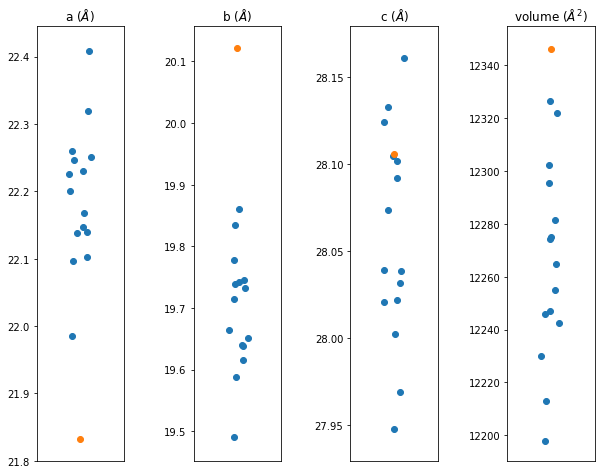

In [12]:
for potential_file in sorted(glob.glob('{}/*/potentials.json'.format(directory))):
    pot_structures = potential_file.replace('/potentials.json', '').replace('{}/'.format(directory),'')
    calculated_parameters = np.loadtxt('{}/{}_lattice_values.dat'.format(output_directory, pot_structures))
    fig, axs = plt.subplots(1, len(labels), figsize=(10,8))
    plt.subplots_adjust(wspace=0.8)
    for i, label in enumerate(labels):
        x = np.random.rand(len(calculated_parameters))
        axs[i].scatter(x, calculated_parameters.transpose()[i])
        axs[i].scatter(0.5, ref_DFT[i])
        axs[i].set_xlim(left=-1.5, right=2.5)
        axs[i].set_xticks([])
        axs[i].set_title('{}'.format(label))
    plt.savefig('{}/{}_lattice_comparison.png'.format(output_directory, pot_structures),dpi=500, bbox_inches = "tight")
    plt.show()

## Plot lattice parameters with distribution curve

In [13]:
def scatter_plot(x,y,ref_DFT,label,gs):
    axs = plt.subplot(gs)
    axs.scatter(x, y)
    axs.scatter(0.5, ref_DFT)
    axs.set_xlim(left=-1.5, right=2.5)
    axs.set_xticks([])
    axs.set_title('{}'.format(label))
    plt.subplots_adjust(wspace=0)
    return axs

def distribution_plot(df_data, gs):
    axs = plt.subplot(gs)
    axs.axis('off')
    axs = sns.kdeplot(y, vertical=True, shade=True)
    return axs

def y_limits(ref_DFT, y):
    if ref_DFT <= y.min():
        ylims = (ref_DFT-(ref_DFT*0.002), y.max()+(y.max()*0.002))
    elif ref_DFT >= y.max():
        ylims = (y.min()-(y.min()*0.002), ref_DFT+(ref_DFT*0.002))
    else:
        ylims = (y.min()-(y.min()*0.002), y.max()+(y.max()*0.002))
    return ylims

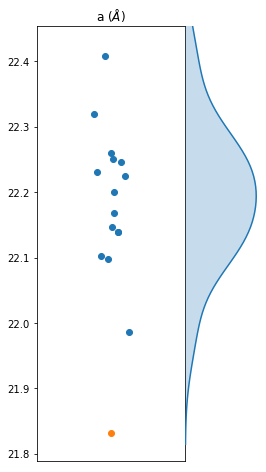

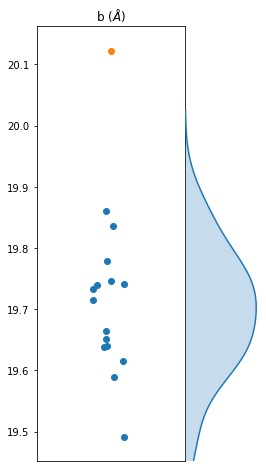

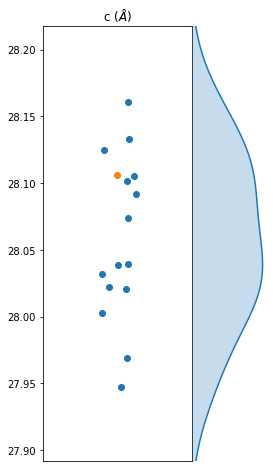

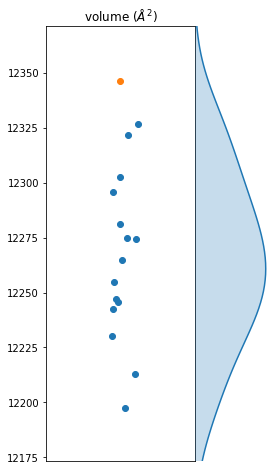

In [14]:
labels = ['a ($\AA$)', 'b ($\AA$)', 'c ($\AA$)', 'volume ($\AA^2$)']
short_labels = ['a', 'b', 'c', 'volume']

for i in range(len(labels)):
    fig, axs = plt.subplots(1, 2, figsize=(4,8), sharey=True)
    plt.subplots_adjust(wspace=0)
    x = np.random.rand(len(calculated_parameters))
    y = calculated_parameters.T[i]
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])

    axs[0] = scatter_plot(x,y,ref_DFT[i],labels[i],gs[0])
    axs[1] = distribution_plot(y, gs[1])
    ylims = y_limits(ref_DFT[i], y)
    axs[0].set_ylim(ylims)
    axs[1].set(ylim =ylims)
#     plt.savefig('results/plots/{}_lattice_comparison.png'.format(short_labels[i]),dpi=500, bbox_inches = "tight")
    plt.show()

## not in use

suppose to print all lattice parameters in one image with the distributions but the distributions overlay the y-axis lables. I haven't worked out how to fixe this yet

In [ ]:
# labels = ['a ($\AA$)', 'b ($\AA$)', 'c ($\AA$)', 'volume ($\AA^2$)']
# fig, axs = plt.subplots(1, 8, figsize=(20,8), sharey=True)
# plt.subplots_adjust(wspace=0.0)
# gs = gridspec.GridSpec(1, 8, width_ratios=[1, 0.5, 1, 0.5, 1, 0.5, 1, 0.5])

# for i, j in enumerate(range(0,8,2)):
#     y = calculated_parameters.T[i]
#     x = np.random.rand(len(y))
#     ylims = y_limits(ref_DFT[i], y)  
#     axs[j] = scatter_plot(x,y,ref_DFT[i],labels[i],gs[j])
#     axs[j+1] = distribution_plot(y, gs[j+1])
#     ylims = y_limits(ref_DFT[i], y)
#     axs[j].set_ylim(ylims)
#     axs[j+1].set(ylim =ylims)
# #     plt.savefig('plots/3_structure_lattice_comparison.png',dpi=500, bbox_inches = "tight")
# plt.show()